# Diabetic retinopathy classification

## 01 Creating feed forward neural network model for inverted images recognition

## Imports

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split as split
import torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image, ImageOps
from torchvision import models, transforms

## Folder path

In [35]:
dirpath = 'D:\project_data\isecene\left'
os.listdir(dirpath)

['i', 'n']

## Inverted images paths

In [36]:
i_path = 'D:\project_data\isecene\left\i'
i_paths = os.listdir(i_path)
#i_paths
i_paths = [os.path.join(i_path, i) for i in i_paths]
#i_paths

## Non-inverted images paths

In [37]:
n_path = 'D:\project_data\isecene\left\\n'
n_paths = os.listdir(n_path)
n_paths = [os.path.join(n_path, n) for n in n_paths]
#n_paths

## Transformations and writing images

## Image preprocessing

In [38]:
# transforms each image to same size before training
preprocess= transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Sample - show transformation

torch.Size([3, 224, 224])

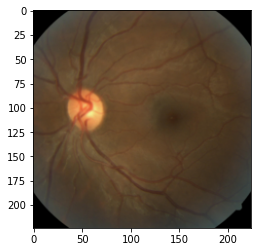

In [39]:
path = n_paths[0]
image = Image.open(path)
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0))
image.shape

### Creating set of preprocessed images

In [40]:
X = torch.zeros((200,3,224,224))
y = torch.zeros((200,1))
y[100:200] = 1

#print(images)

paths = n_paths + i_paths

for i,p in enumerate(paths):
    image = Image.open(p)
    image = preprocess(image)
    X[i] = image    

In [41]:
X.shape

torch.Size([200, 3, 224, 224])

## Spliting test & train samples

In [42]:
test_size = 0.2
X_train, X_test, y_train, y_test = split(X, y, test_size = test_size, random_state = 7)

## Creating datasets

In [43]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=X
        self.y=y
        self.samples=X.shape[0]
        self.features=X.shape[2]*X.shape[3]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.samples

In [44]:
train_data=Data(X_train, y_train)
test_data=Data(X_test, y_test)

In [45]:
train_data.samples, test_data.samples

(160, 40)

In [46]:
train_data.features, 224*224

(50176, 50176)

In [58]:
input_size = 3*train_data.features
num_classes = 2
learning_rate = 0.01
hidden_size = 100
num_epochs = 300

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
# training class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
        
model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# train

for epoch in range(num_epochs):
    # 32, 3, 256, 256 > 32, 3 * 224 * 224
    # to device - to GPU if exists
    images = train_data.x.reshape(-1, 3*224*224).to(device) 
    labels = train_data.y.to(device)

    labels = labels.reshape(160)

    outputs = model(images)
    loss = criterion(outputs, labels.long())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f'epoch {epoch+1} / {num_epochs}, loss = {loss.item():.4f}')

# test
with torch.no_grad():
  
    images = test_data.x.reshape(-1, 3*224*224).to(device) 
    labels = test_data.y.to(device)
    outputs = model(images)

    _, predictions = torch.max(outputs.data, 1)
    n_samples = labels.size(0)
    n_corect = (predictions.reshape(40) == labels.reshape(40)).sum()
        
    acc = 100 * n_corect / n_samples
    
    print(predictions)
    
    print(f'accuracy: {acc}%')  

epoch 1 / 300, loss = 0.7082
epoch 6 / 300, loss = 3.0236
epoch 11 / 300, loss = 8.0148
epoch 16 / 300, loss = 3.8756
epoch 21 / 300, loss = 2.7651
epoch 26 / 300, loss = 2.3467
epoch 31 / 300, loss = 1.5900
epoch 36 / 300, loss = 1.0153
epoch 41 / 300, loss = 0.9004
epoch 46 / 300, loss = 0.6094
epoch 51 / 300, loss = 0.5129
epoch 56 / 300, loss = 0.3832
epoch 61 / 300, loss = 0.2728
epoch 66 / 300, loss = 0.2495
epoch 71 / 300, loss = 0.2036
epoch 76 / 300, loss = 0.2085
epoch 81 / 300, loss = 0.1839
epoch 86 / 300, loss = 0.1587
epoch 91 / 300, loss = 0.1375
epoch 96 / 300, loss = 0.1201
epoch 101 / 300, loss = 0.1035
epoch 106 / 300, loss = 0.0875
epoch 111 / 300, loss = 0.0736
epoch 116 / 300, loss = 0.0611
epoch 121 / 300, loss = 0.0503
epoch 126 / 300, loss = 0.0405
epoch 131 / 300, loss = 0.0311
epoch 136 / 300, loss = 0.0224
epoch 141 / 300, loss = 0.0151
epoch 146 / 300, loss = 0.0100
epoch 151 / 300, loss = 0.0068
epoch 156 / 300, loss = 0.0049
epoch 161 / 300, loss = 0.0037

In [61]:
torch.save(model.state_dict(),'invertor_model_95.pt')